# Install detectron2

In [1]:
#dependencies
!pip install --upgrade pip
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
torchvision.__version__
!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.0.2)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 27 kB/s s eta 0:00:01  |▎                               | 5.1 MB 514 kB/s eta 0:23:19     |▌                               | 11.4 MB 514 kB/s eta 0:23:06     |██                              | 45.2 MB 48.0 MB/s eta 0:00:15     |███                             | 66.1 MB 31.9 MB/s eta 0:00:21     |████                            | 89.1 MB 31.9 MB/s eta 0:00:20     |█████▉                          | 130.9 MB 60.1 MB/s eta 0:00:10     |████████▉                       | 199.6 MB 61.1 MB/s eta 0:00:09     |███████████▎                    | 254.5 MB 60.1 MB/s eta 0:00:08     |█████████████▋                  | 308.4 MB 40.2 MB/s eta 0:00:11     |█████████████████▋              | 398.8 MB 59.5 MB/s eta 0:00:06     |█████████████████▉              | 403.8 MB 59.5 MB/s eta 0:00:06████████       

  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=279379 sha256=2cb7ee6073b3d0e9f329e2289f77dfe90edeec1f90438b9ec87867e086b3799f
  Stored in directory: /tmp/pip-ephem-wheel-cache-32a8nshe/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2 MB 812 kB/s eta 0:00:01     |███████▉                        | 1.5 MB 291 kB/s eta 0:00:17     |████████████████████████▏       | 4.7 MB 812 kB/s eta 0:00:02
  Created wheel for fvcore: filename=fvcore-0.1.dev200307-py3-none-any.whl size=37811 sha256=8d768b38385ebe0fe289c3fe3a4523095916a0578c61367c88

# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from tqdm import tqdm_notebook as tqdm
import PIL
from PIL import Image
import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util
import fastai
from fastai import vision
import matplotlib.pyplot as plt
 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution'

seed = 19
np.random.seed(seed)

# util functions

In [2]:
def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->np.array:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np(arr:np.array):
    plt.imshow(arr)
    plt.show()
    
def merge_masks(masks:List[np.array], shape:tuple=(256,256))->np.array:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple)->np.array:
    masks = [open_mask_as_np(p) for p in path.ls()]
    return merge_masks(masks, shape)

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->np.array:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns numpy array, True == mask, False == background

    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[np.array]:
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        masks.append(rle_decode(row[coloumn_name_rle]))
    return masks

# dataset

## load csv

In [3]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [4]:
s1_trn_lbs_df

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
...,...,...
29456,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...
29457,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,110318 4 110675 13 111034 19 111391 23 111750 ...
29458,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...
29459,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...


In [5]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

## merge existing single masks of one image

In [6]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [7]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

PosixPath('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks')

In [8]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [9]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

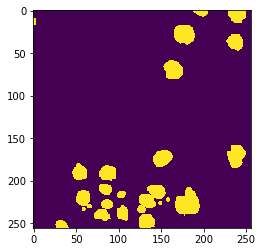

In [10]:
show_np(merged_mask)

## decode run length encoding to mask

In [11]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [12]:
merged_mask = merge_masks(masks)

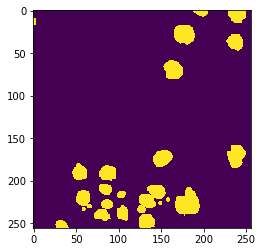

In [13]:
show_np(merged_mask)